<a href="https://colab.research.google.com/github/chefhaider/Fake-News-Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
pip install pyspellchecker

In [24]:
import re
import string


import nltk
from nltk.corpus import stopwords


import numpy as np
import pandas as pd
import requests


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split


from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from sklearn.multiclass import OneVsRestClassifier
from spellchecker import SpellChecker


from keras import Sequential
from keras.layers import Dense



In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/train.csv')

In [27]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [29]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [30]:
len(df.location.unique())

3342

In [31]:
'''import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


df = pd.read_csv('https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/train.csv')


geolocator = Nominatim(user_agent = "geoapiExercises")
city_name = []




for val in df.location:
  if val == 'nan':
    city_name+=[' ']
    continue

  try:
    city_name+=[ geolocator.geocode(val)[-2].split(',')[-1] ]
  except TypeError:
    city_name+=[' ']
  except GeocoderTimedOut :
    city_name+=[' ']'''

'import pandas as pd\nfrom geopy.geocoders import Nominatim\nfrom geopy.exc import GeocoderTimedOut\n\n\ndf = pd.read_csv(\'https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/train.csv\')\n\n\ngeolocator = Nominatim(user_agent = "geoapiExercises")\ncity_name = []\n\n\n\n\nfor val in df.location:\n  if val == \'nan\':\n    city_name+=[\' \']\n    continue\n\n  try:\n    city_name+=[ geolocator.geocode(val)[-2].split(\',\')[-1] ]\n  except TypeError:\n    city_name+=[\' \']\n  except GeocoderTimedOut :\n    city_name+=[\' \']'

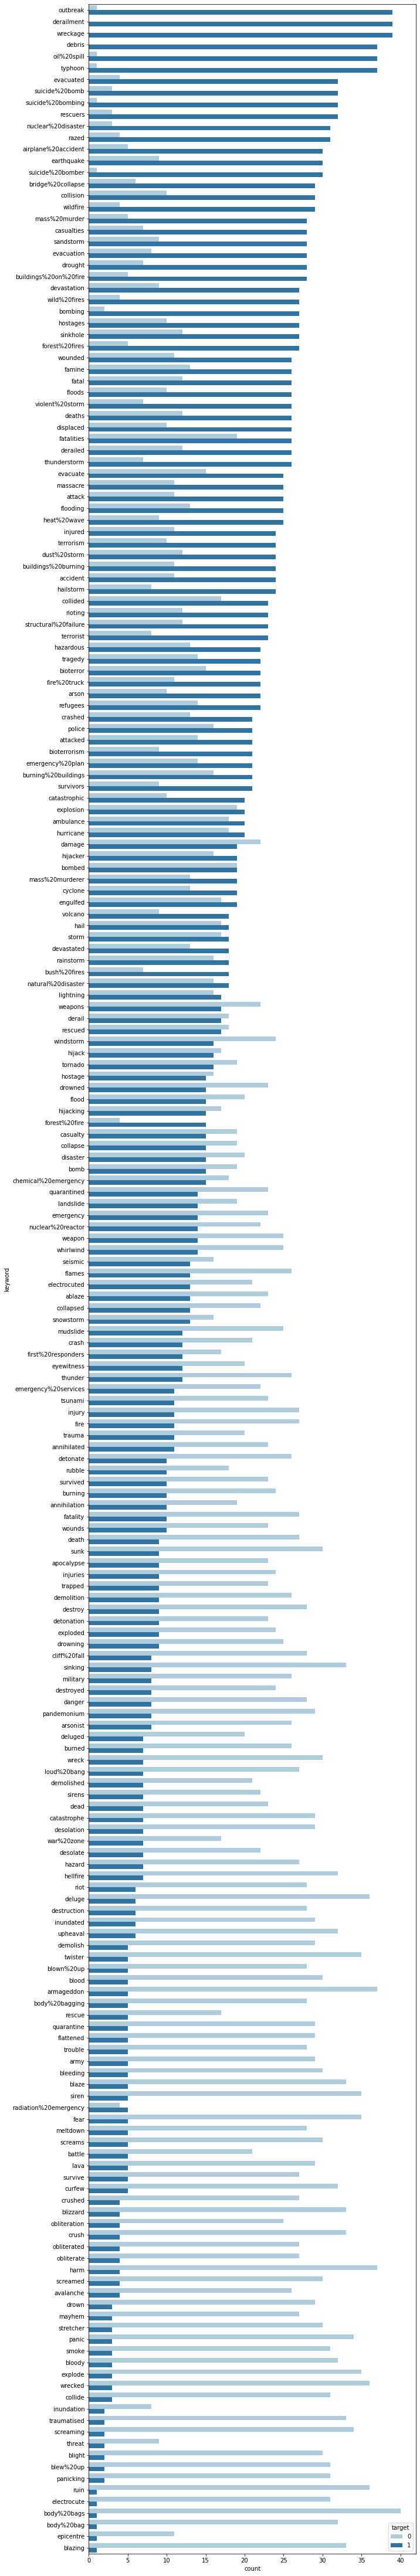

In [32]:
fig = plt.figure(figsize=(10,80))
sns.countplot(y="keyword",order=df[df.target == 1]['keyword'].value_counts().index, hue="target",data = df,palette='Paired')

In [33]:
df.dropna(subset = ["keyword"], inplace=True)
#df.reset_index(drop=True, inplace=True)

In [34]:





def clean_text(text):


    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)


    html=re.compile(r'<.*?>')
    text = html.sub(r'',text)



    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)


    table=str.maketrans('','',string.punctuation)
    return text.translate(table)



df['text'] = df['text'].apply(lambda x: clean_text(x))


In [35]:
'''
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

df['text'] = df['text'].apply(lambda x: correct_spellings(x))'''

'\nspell = SpellChecker()\n\ndef correct_spellings(text):\n    corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)\n\ndf[\'text\'] = df[\'text\'].apply(lambda x: correct_spellings(x))'

In [36]:
X_train,X_test,y_train,y_test = train_test_split(df[['text','keyword']], df['target'], test_size=0.4, random_state=42)

In [37]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

m_model = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
m_model.fit(X_train['text'].values, y_train)

print("Best parameters set:")
print( m_model.best_estimator_.steps )


pred = m_model.predict(X_test['text'])
print(classification_report(y_test, pred ))



Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:    8.2s finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.25, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)), ('clf', OneVsRestClassifier(estimator=Multi

In [38]:



pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('clf', OneVsRestClassifier(BernoulliNB(
        fit_prior=True, class_prior=None))),
])
parameters = {
    'clf__estimator__alpha': (1e-2, 1e-3)
}

b_model = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
b_model.fit(X_train['keyword'].values, y_train)

print("Best parameters set:")
print( b_model.best_estimator_.steps )


pred = b_model.predict(X_test['keyword'])
print(classification_report(y_test, pred ))



Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best parameters set:
[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)), ('clf', OneVsRestClassifier(estimator=BernoulliNB(alpha=0.01, binarize=0.0,
                                          class_prior=None, fit_prior=True),
                    n_jobs=None))]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1733
           1       0.69      0.67      0.68      1288

    accuracy                           0.73      3021
   macro avg       0.72      0.72      0.72      3021
weighted avg       0.73      0.73      0.73      3021



![alt text]('https://i.ibb.co/km70Wk6/IMG-20210603-142542.jpg')*italicized text*

In [39]:
def naiveBayesClassifier(df,prob_text,prob_keyword):

  prob_1 = df.value_counts()[1]/len(y_train)

  return [ int( ( ( val1[1] * val0[1] ) / prob_1 ) > .5 ) for val1,val0 in zip(prob_text,prob_keyword) ]

joint_prob  =   naiveBayesClassifier(y_train,m_model.predict_proba(X_test['text']),b_model.predict_proba(X_test['keyword']))
print(classification_report(y_test, joint_prob))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1733
           1       0.78      0.69      0.74      1288

    accuracy                           0.79      3021
   macro avg       0.79      0.78      0.78      3021
weighted avg       0.79      0.79      0.79      3021



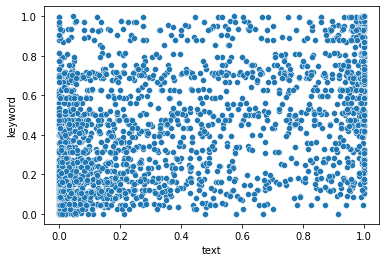

In [40]:
text_prob = [ val[1] for val in m_model.predict_proba(X_test['text']) ]
keyword_prob = [ val[1] for val in  b_model.predict_proba(X_test['keyword']) ]

prob_df = pd.DataFrame()
prob_df['text'] = text_prob
prob_df['keyword'] = keyword_prob

sns.scatterplot(data=prob_df, x="text", y="keyword")

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0 )
predicts = kmeans.fit_predict(prob_df)

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1733
           1       0.77      0.72      0.74      1288

    accuracy                           0.79      3021
   macro avg       0.78      0.78      0.78      3021
weighted avg       0.79      0.79      0.79      3021



In [42]:
prob_df

,text,keyword
0,1.000000,0.955695
1,0.845562,0.176354
2,0.020283,0.025202
3,0.039881,0.121991
4,0.339879,0.409961
...,...,...
3016,0.021187,0.626635
3017,0.728972,0.803416
3018,0.072615,0.107409
3019,0.019404,0.520579


In [43]:
target = np.array(y_test)


X_train,X_test,y_train,y_test = train_test_split(prob_df[['keyword','text']],target, test_size=0.3, random_state=42)

classifier = Sequential()
#First Hidden Layer
#classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=2))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))


#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=10, epochs=100)


eval_model=classifier.evaluate(X_train, y_train)

predicts = classifier.predict(X_test)
predicts =(predicts>0.5)
print(classification_report(y_test, predicts))

Epoch 1/100
212/212 [==============================] - 22s 1ms/step - loss: 0.6894 - accuracy: 0.6353
Epoch 2/100
212/212 [==============================] - 0s 1ms/step - loss: 0.6591 - accuracy: 0.7843
Epoch 3/100
212/212 [==============================] - 0s 1ms/step - loss: 0.6234 - accuracy: 0.7400
Epoch 4/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5911 - accuracy: 0.7556
Epoch 5/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5652 - accuracy: 0.7625
Epoch 6/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5364 - accuracy: 0.7790
Epoch 7/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5306 - accuracy: 0.7661
Epoch 8/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5149 - accuracy: 0.7917
Epoch 9/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5079 - accuracy: 0.7746
Epoch 10/100
212/212 [==============================] - 0s 1ms/step - loss: 0.5149 - accur

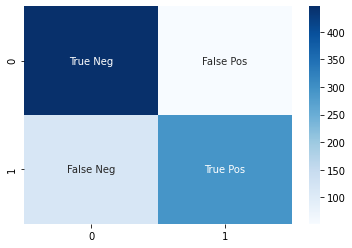

In [44]:
cf_matrix = confusion_matrix(y_test, predicts)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [45]:
'''test = pd.read_csv('https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/test.csv')



test['text'] = test['text'].apply(lambda x: clean_text(x))
tf_idf_mat_test = tf_idf_vect.transform(test['text'].values) # fit_transform vectorizer to dtest['text']
predictions = clf.predict(tf_idf_mat_test)

output = pd.DataFrame({'id': test.id, 'target': predictions})
output.to_csv('my_submission.csv', index=False)'''

"test = pd.read_csv('https://raw.githubusercontent.com/chefhaider/Fake-News-Detection-Kaggle/main/test.csv')\n\n\n\ntest['text'] = test['text'].apply(lambda x: clean_text(x))\ntf_idf_mat_test = tf_idf_vect.transform(test['text'].values) # fit_transform vectorizer to dtest['text']\npredictions = clf.predict(tf_idf_mat_test)\n\noutput = pd.DataFrame({'id': test.id, 'target': predictions})\noutput.to_csv('my_submission.csv', index=False)"